In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import re
import os

def clean_vitals(vitals_str):
    """Extracts numerical values from the vitals string."""
    hr = re.search(r'HR: (\d+)', vitals_str)
    bp_match = re.search(r'BP: (\d+)/(\d+)', vitals_str)
    o2 = re.search(r'O2: (\d+)', vitals_str)

    hr_val = int(hr.group(1)) if hr else -1
    bp_sys_val = int(bp_match.group(1)) if bp_match else -1
    bp_dia_val = int(bp_match.group(2)) if bp_match else -1
    o2_val = int(o2.group(1)) if o2 else -1

    return hr_val, bp_sys_val, bp_dia_val, o2_val

def train_triage_model():
    """
    Trains a Gradient Boosting Classifier to predict the clinical outcome
    based on incident report details.
    """
    print("Starting triage model training...")

    # --- 1. Load and Prepare Data ---
    try:
        data_path = "/content/triage_dataset.csv"
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Error: The dataset was not found at {data_path}")
        print("Please ensure 'triage_dataset.csv' is in the '/content/' directory.")
        return

    print(f"Loaded {len(df)} records from the dataset.")

    # --- 2. Feature Engineering ---
    df[['hr', 'bp_sys', 'bp_dia', 'o2']] = df['vitals'].apply(lambda x: pd.Series(clean_vitals(x)))
    df.drop('vitals', axis=1, inplace=True)

    # Define features (X) and target (y)
    X = df.drop('outcome', axis=1)
    y = df['outcome']

    # Encode the target variable
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    print(f"Target classes found: {le.classes_}")

    # --- 3. Preprocessing Pipeline ---
    # Define which columns are which type
    text_feature = 'caller_report'
    numeric_features = ['age', 'hr', 'bp_sys', 'bp_dia', 'o2']
    categorical_feature = 'time_of_day'

    # Create a preprocessor that handles text, numeric, and categorical features separately
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(stop_words='english', max_features=150), text_feature),
            ('numeric', 'passthrough', numeric_features),
            ('categorical', OneHotEncoder(handle_unknown='ignore'), [categorical_feature])
        ],
        remainder='drop'
    )

    # --- 4. Model Training ---
    # Create the full pipeline including the preprocessor and the classifier
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
    ])

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")

    # Train the model
    model_pipeline.fit(X_train, y_train)
    print("Model training completed.")

    # --- 5. Evaluation ---
    y_pred = model_pipeline.predict(X_test)
    print("\n--- Model Evaluation ---")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # --- 6. Serialization ---
    # Save the trained pipeline (preprocessor + model) and the label encoder
    output_dir = 'triage_output'
    os.makedirs(output_dir, exist_ok=True)

    model_path = os.path.join(output_dir, 'triage_model.pkl')
    label_encoder_path = os.path.join(output_dir, 'triage_label_encoder.pkl')

    joblib.dump(model_pipeline, model_path)
    joblib.dump(le, label_encoder_path)

    print(f"Trained model pipeline saved to: {model_path}")
    print(f"Label encoder saved to: {label_encoder_path}")
    print("\nTraining process finished successfully.")

    return model_pipeline, X, y_encoded, X_train, X_test, y_train, y_test, y_pred, le

model_pipeline, X, y_encoded, X_train, X_test, y_train, y_test, y_pred, le = train_triage_model()

Starting triage model training...
Loaded 50 records from the dataset.
Target classes found: ['Discharge' 'Hospital Admission' 'ICU Admission']
Training on 40 samples, testing on 10 samples.
Model training completed.

--- Model Evaluation ---
                    precision    recall  f1-score   support

         Discharge       1.00      1.00      1.00         3
Hospital Admission       0.80      1.00      0.89         4
     ICU Admission       1.00      0.67      0.80         3

          accuracy                           0.90        10
         macro avg       0.93      0.89      0.90        10
      weighted avg       0.92      0.90      0.90        10

Accuracy: 0.9
Trained model pipeline saved to: triage_output/triage_model.pkl
Label encoder saved to: triage_output/triage_label_encoder.pkl

Training process finished successfully.


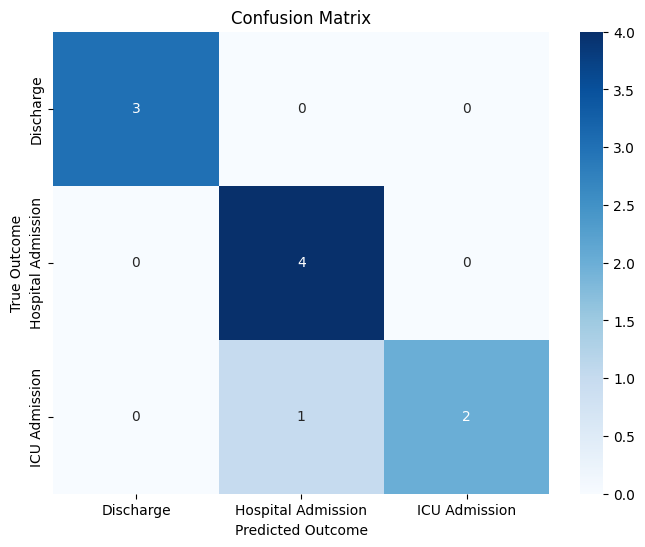

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are available from the previous training cell
# If not, you would need to reload the model and data to generate them

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Outcome')
plt.ylabel('True Outcome')
plt.title('Confusion Matrix')
plt.show()

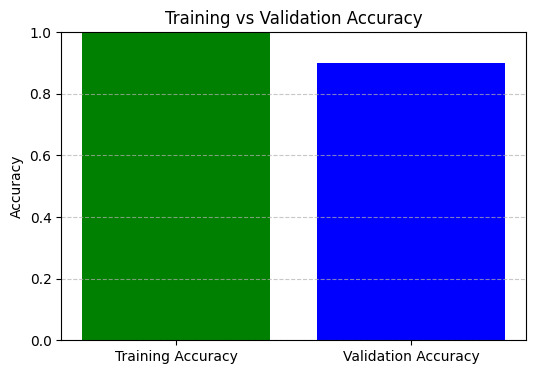

In [ ]:
import matplotlib.pyplot as plt

# Calculate accuracies
train_acc = model_pipeline.score(X_train, y_train)
test_acc = model_pipeline.score(X_test, y_test)

# Plot bar graph
plt.figure(figsize=(6,4))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_acc, test_acc], color=['green', 'blue'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

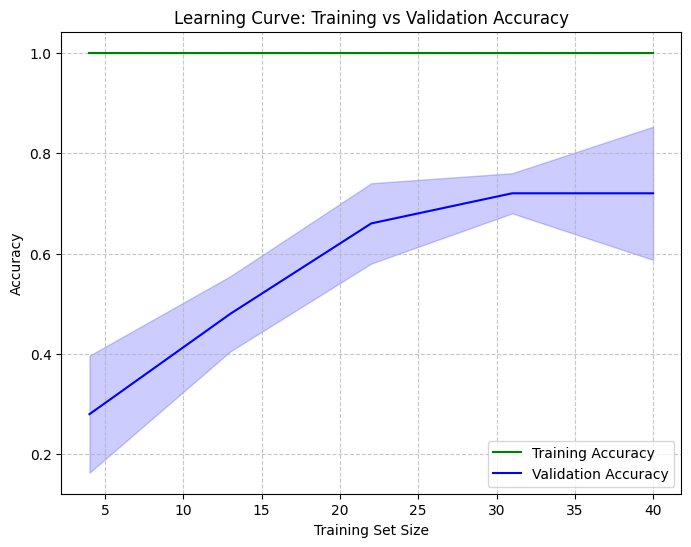

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    model_pipeline, X, y_encoded, cv=5, scoring='accuracy', n_jobs=-1
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='green')

plt.plot(train_sizes, val_mean, label='Validation Accuracy', color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='blue')

plt.title('Learning Curve: Training vs Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()